In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

In [4]:
!cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 8\ Assignment/model_bn.py /content
!cp /content/drive/MyDrive/The\ School\ of\ AI/Session\ 8\ Assignment/utils.py /content

In [5]:
import model_bn
import utils
from model_bn import Net
from utils import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA Available? True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA Available? True


In [6]:
# Train data transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test data transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])

In [7]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
#test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms) --> Commented the incorrect line. train = False and test_transform needs to be passed
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:03<00:00, 46149437.18it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [8]:
type(train_data), len(train_data), len(train_data[0]), train_data.data.shape, test_data.data.shape

(torchvision.datasets.cifar.CIFAR10,
 50000,
 2,
 (50000, 32, 32, 3),
 (10000, 32, 32, 3))

In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


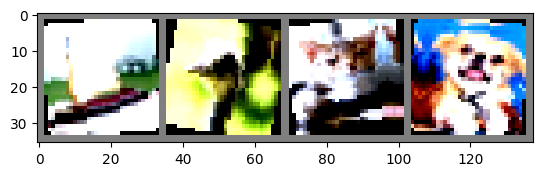

ship  bird  cat   dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

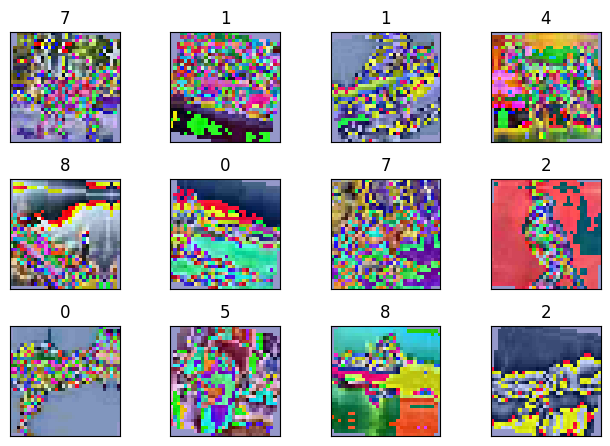

In [ ]:
#batch_data, batch_label = next(iter(train_loader))
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  #plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.imshow(transforms.ToPILImage()(batch_data[i]),interpolation='nearest')
  #plt.imshow(batch_data[i].squeeze(0))
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.600526213645935 Batch_id=97 Accuracy=32.69: 100%|██████████| 98/98 [00:35<00:00,  2.77it/s]



Test set: Average loss: 1.5886, Accuracy: 4263/10000 (42.63%)

EPOCH: 1


Loss=1.4953831434249878 Batch_id=97 Accuracy=45.76: 100%|██████████| 98/98 [00:37<00:00,  2.62it/s]



Test set: Average loss: 1.3504, Accuracy: 5021/10000 (50.21%)

EPOCH: 2


Loss=1.3484278917312622 Batch_id=97 Accuracy=52.13: 100%|██████████| 98/98 [00:36<00:00,  2.70it/s]



Test set: Average loss: 1.2346, Accuracy: 5558/10000 (55.58%)

EPOCH: 3


Loss=1.182269811630249 Batch_id=97 Accuracy=56.08: 100%|██████████| 98/98 [00:36<00:00,  2.71it/s]



Test set: Average loss: 1.1929, Accuracy: 5731/10000 (57.31%)

EPOCH: 4


Loss=1.1392563581466675 Batch_id=97 Accuracy=58.27: 100%|██████████| 98/98 [00:38<00:00,  2.58it/s]



Test set: Average loss: 1.0901, Accuracy: 6039/10000 (60.39%)

EPOCH: 5


Loss=0.942803144454956 Batch_id=97 Accuracy=60.02: 100%|██████████| 98/98 [00:35<00:00,  2.72it/s]



Test set: Average loss: 1.0342, Accuracy: 6261/10000 (62.61%)

EPOCH: 6


Loss=1.1611391305923462 Batch_id=97 Accuracy=62.14: 100%|██████████| 98/98 [00:37<00:00,  2.62it/s]



Test set: Average loss: 1.0366, Accuracy: 6327/10000 (63.27%)

EPOCH: 7


Loss=1.0782917737960815 Batch_id=97 Accuracy=62.80: 100%|██████████| 98/98 [00:36<00:00,  2.69it/s]



Test set: Average loss: 0.9421, Accuracy: 6658/10000 (66.58%)

EPOCH: 8


Loss=1.0082136392593384 Batch_id=97 Accuracy=64.23: 100%|██████████| 98/98 [00:36<00:00,  2.72it/s]



Test set: Average loss: 0.9118, Accuracy: 6773/10000 (67.73%)

EPOCH: 9


Loss=0.950792670249939 Batch_id=97 Accuracy=65.42: 100%|██████████| 98/98 [00:38<00:00,  2.57it/s]



Test set: Average loss: 0.8901, Accuracy: 6849/10000 (68.49%)

EPOCH: 10


Loss=0.8800854682922363 Batch_id=97 Accuracy=65.97: 100%|██████████| 98/98 [00:35<00:00,  2.73it/s]



Test set: Average loss: 0.8632, Accuracy: 6890/10000 (68.90%)

EPOCH: 11


Loss=0.9138841032981873 Batch_id=97 Accuracy=66.91: 100%|██████████| 98/98 [00:37<00:00,  2.64it/s]



Test set: Average loss: 0.8380, Accuracy: 7002/10000 (70.02%)

EPOCH: 12


Loss=0.8825550079345703 Batch_id=97 Accuracy=67.50: 100%|██████████| 98/98 [00:35<00:00,  2.73it/s]



Test set: Average loss: 0.7850, Accuracy: 7240/10000 (72.40%)

EPOCH: 13


Loss=0.8561062812805176 Batch_id=97 Accuracy=68.09: 100%|██████████| 98/98 [00:35<00:00,  2.73it/s]



Test set: Average loss: 0.7972, Accuracy: 7146/10000 (71.46%)

EPOCH: 14


Loss=0.9594886302947998 Batch_id=97 Accuracy=68.73: 100%|██████████| 98/98 [00:37<00:00,  2.61it/s]



Test set: Average loss: 0.7661, Accuracy: 7309/10000 (73.09%)

EPOCH: 15


Loss=0.9294711351394653 Batch_id=97 Accuracy=69.39: 100%|██████████| 98/98 [00:36<00:00,  2.72it/s]



Test set: Average loss: 0.7601, Accuracy: 7310/10000 (73.10%)

EPOCH: 16


Loss=0.9419002532958984 Batch_id=97 Accuracy=69.78: 100%|██████████| 98/98 [00:38<00:00,  2.57it/s]



Test set: Average loss: 0.7754, Accuracy: 7251/10000 (72.51%)

EPOCH: 17


Loss=0.8183392882347107 Batch_id=97 Accuracy=70.47: 100%|██████████| 98/98 [00:35<00:00,  2.75it/s]



Test set: Average loss: 0.7053, Accuracy: 7488/10000 (74.88%)

EPOCH: 18


Loss=0.853950023651123 Batch_id=97 Accuracy=70.61: 100%|██████████| 98/98 [00:37<00:00,  2.63it/s]



Test set: Average loss: 0.7518, Accuracy: 7338/10000 (73.38%)

EPOCH: 19


Loss=0.7824472784996033 Batch_id=97 Accuracy=71.09: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.7240, Accuracy: 7465/10000 (74.65%)



In [ ]:
model

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock5): Se

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 10
conv_layers


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


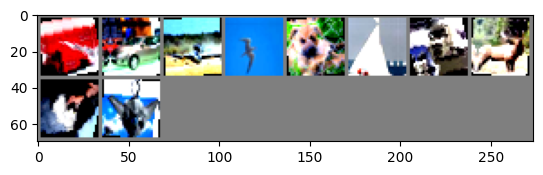

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

In [ ]:
def get_incorrrect_predictions(model, loader, device):
    """Get all incorrect predictions

    Args:
        model (Net): Trained model
        loader (DataLoader): instance of data loader
        device (str): Which device to use cuda/cpu

    Returns:
        list: list of all incorrect predictions and their corresponding details
    """
    model.eval()
    incorrect = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            pred = output.argmax(dim=1)
            for d, t, p, o in zip(data, target, pred, output):
                if p.eq(t.view_as(p)).item() == False:
                    incorrect.append(
                        [d.cpu(), t.cpu(), p.cpu(), o[p.item()].cpu()])

    return incorrect

In [ ]:
def plot_incorrect_predictions(predictions, class_map, count=10):
    """Plot Incorrect predictions

    Args:
        predictions (list): List of all incorrect predictions
        class_map (dict): Lable mapping
        count (int, optional): Number of samples to print, multiple of 5. Defaults to 10.
    """
    print(f'Total Incorrect Predictions {len(predictions)}')

    if not count % 5 == 0:
        print("Count should be multiple of 10")
        return

    classes = list(class_map.values())

    fig = plt.figure(figsize=(10, 5))
    for i, (d, t, p, o) in enumerate(predictions):
        ax = fig.add_subplot(int(count/5), 5, i + 1, xticks=[], yticks=[])
        ax.set_title(f'{classes[t.item()]}/{classes[p.item()]}')
        plt.imshow(d.cpu().numpy().transpose(1, 2, 0))
        if i+1 == 5*(count/5):
            break

In [ ]:
class_map = {
    'ZERO': 'plane',
    'ONE': 'car',
    'TWO': 'bird',
    'THREE': 'cat',
    'FOUR': 'deer',
    'FIVE': 'dog',
    'SIX': 'frog',
    'SEVEN': 'horse',
    'EIGHT': 'ship',
    'NINE': 'truck'
}

Total Incorrect Predictions 2535


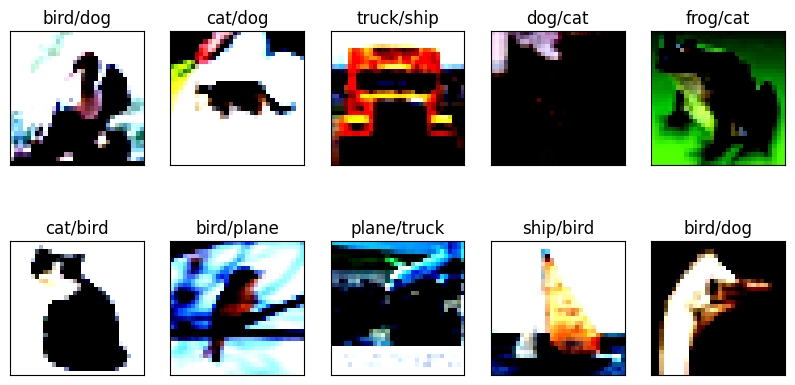

In [ ]:
incorrect = get_incorrrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)